# Syed scRNA Data Analysis both rep1 and rep2
This is a jupyter notebook to process Syed's single-cell RNA-seq data. A objective of the project is as follows

We cannot do a heterogeneous analysis on a mixture of populations using the dataset from the previous call, even if we combine them into a single dataset to create a synthetic heterogeneous population of tumour tissue. This limitation stems from the data being generated from two different Fluidigm runs, and any observed heterogeneity in this can be just due to the batch effect of different runs. In addition, it is not clear which type of data will perform best in tumour heterogeneity analysis. Typically, RNA-seq is used but suffers due to dynamic range issues resulting in sparse data. Alternatively, due to the more binary nature of open chromatin signals, ATAC-seq has the potential to be more useful for identifying cellular subpopulation in a complex tissue. 

__Aim:__ The aim of this project is twofold:
- To develop a computational method to classify each cell within a mixed cell population.
- To compare ATAC-seq with RNA-seq and identify the most appropriate assay for such analyses.

In [1]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import rpy2.interactive as r
import rpy2.interactive.packages # this can take few seconds
import time
import pylab
import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(scde)
library(DESeq2)
library(ggplot2)
library(made4)
library(irlba)
library(scater)
library(scran)
library(ComplexHeatmap)
library(genefilter)
library(ccRemover)
library(Rtsne)
library(plotly)
library(MASS)
library(M3Drop)

Reading the gene names of zebra fish

In [5]:
%%R
GeneName <- read.table("/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/AllReads/GeneNames.txt")

Reading the count files. I had to modify the count files as it had the no_features stats generated from the htseq tool. I removed those information as they are not needed for this analysis.

In [14]:
%%R
cdRep1 <- read.table("/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/AllReads/AllHtseqCounts_Rep1.csv", sep=",",header=TRUE, row.names=1)
cdRep2 <- read.table("/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/AllReads/AllHtseqCounts_Rep2.csv", sep=",",header=TRUE, row.names=1)

cdAnnotRep1 <- cdRep1
colnames(cdAnnotRep1) <- gsub('(_).*','_rep1', colnames(cdAnnotRep1))
rownames(cdAnnotRep1) <- make.names(GeneName$V1, unique=TRUE)
#colnames(cdStromal) <- sub("_.*", "_Stromal", colnames(cdStromal))
write.csv(cdAnnotRep1,'/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/AllReads/cdAnnotRep1.csv')

cdAnnotRep2 <- cdRep2
colnames(cdAnnotRep2) <- gsub('(_).*','_rep2', colnames(cdAnnotRep2))
rownames(cdAnnotRep2) <- make.names(GeneName$V1, unique=TRUE)
#colnames(cdStromal) <- sub("_.*", "_Stromal", colnames(cdStromal))
write.csv(cdAnnotRep2,'/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/AllReads/cdAnnotRep2.csv')

cdAnnotAll <- cbind(cdAnnotRep1, cdAnnotRep2)
write.csv(cdAnnotAll,'/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/AllReads/cdAnnotAll.csv')

In [76]:
%%R
MappingSummary <- read.table("/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/read_summary/MappingSummary_scRNA.csv", sep=",",header=TRUE, row.names=1)
MappingSummary$CellName <- colnames(cdAnnotAll)
mRNAno <- colSums(cdAnnotAll)
MappingSummary$mRNAno <- mRNAno
MappingSummary$unmapped_ratios <- MappingSummary$Percent_Uniquely_Mapped/MappingSummary$Percent_of_unmapped

cdAnnotBinary <- cdAnnotAll
cdAnnotBinary[cdAnnotBinary > 0] <- 1
No_of_Genes_Detected <- colSums(cdAnnotBinary)

MappingSummary$No_Genes_Detected <- No_of_Genes_Detected

Percent of cells with percent of unmapped reads lower than 20%

In [28]:
%%R
(sum(MappingSummary$Percent_of_unmapped < 20)/dim(cdAnnotAll)[2])*100

[1] 84.375


## QC analysis
At the start of the QC analysis we do different plots to visualize the summary statistics for the mapped and unmapped reads

- <span style="color:red"> __ The QC might change as I have not got the visual annotation. The number of 0 and 1 cells I put looking at the excel sheet __ </span>

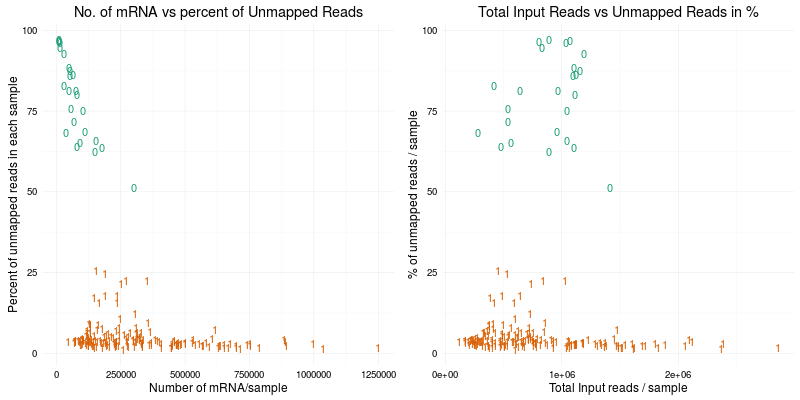

In [29]:
%%R -w 800 -h 400
df<-data.frame(X=mRNAno,Y=MappingSummary$Percent_of_unmapped, CellStatus=as.factor(MappingSummary$CellNumber))
p1 <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) + 
      ggtitle("No. of mRNA vs percent of Unmapped Reads") +
      geom_text(aes(label = MappingSummary$CellNumber)) +
      #geom_point(size=1.25) +
      labs(x = "Number of mRNA/sample", y = "Percent of unmapped reads in each sample") +
      scale_color_brewer(palette = "Dark2") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

df<-data.frame(X=MappingSummary$Number_of_input_reads,Y=MappingSummary$Percent_of_unmapped, CellStatus=as.factor(MappingSummary$CellNumber))
p <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Total Input Reads vs Unmapped Reads in %") +
     geom_text(aes(label = MappingSummary$CellNumber)) +
     labs(x = "Total Input reads / sample", y = "% of unmapped reads / sample") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()+
     theme(legend.position = "none",
           legend.background = element_rect(fill = "white"),
           strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())

multiplot(p1, p, cols=2)

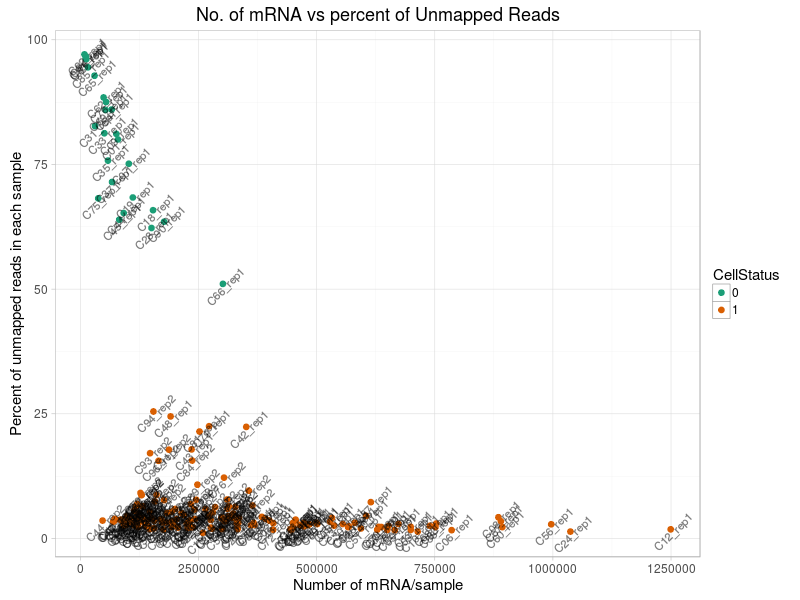

In [40]:
%%R -w 800 -h 600
df<-data.frame(X=mRNAno,Y=MappingSummary$Percent_of_unmapped, CellStatus=as.factor(MappingSummary$CellNumber), 
               Replicate = as.factor(MappingSummary$ReplicateNumber))
p <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) +     
     geom_point(size=2.5) +
     ggtitle("No. of mRNA vs percent of Unmapped Reads") +
     labs(x = "Number of mRNA/sample", y = "Percent of unmapped reads in each sample") +
     scale_color_brewer(palette = "Dark2") +
     theme_light(base_size=15) +
     geom_text(data=df,aes(label=names(mRNAno)),
               alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
p

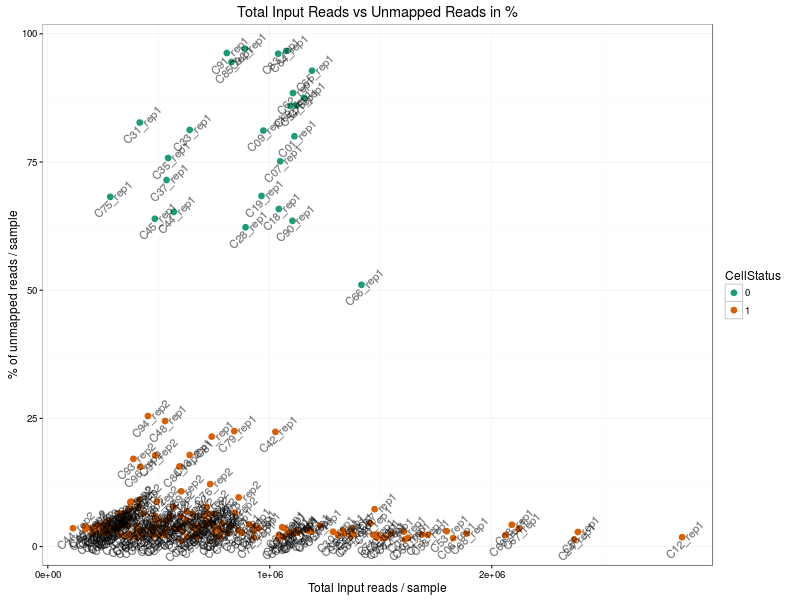

In [41]:
%%R -w 800 -h 600
df<-data.frame(X=MappingSummary$Number_of_input_reads,Y=MappingSummary$Percent_of_unmapped, CellStatus=as.factor(MappingSummary$CellNumber))
p <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Total Input Reads vs Unmapped Reads in %") +
     geom_point(size=2.5) +
     labs(x = "Total Input reads / sample", y = "% of unmapped reads / sample") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()+
     geom_text(data=df,aes(label=names(mRNAno)),
               alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
           

print(p)

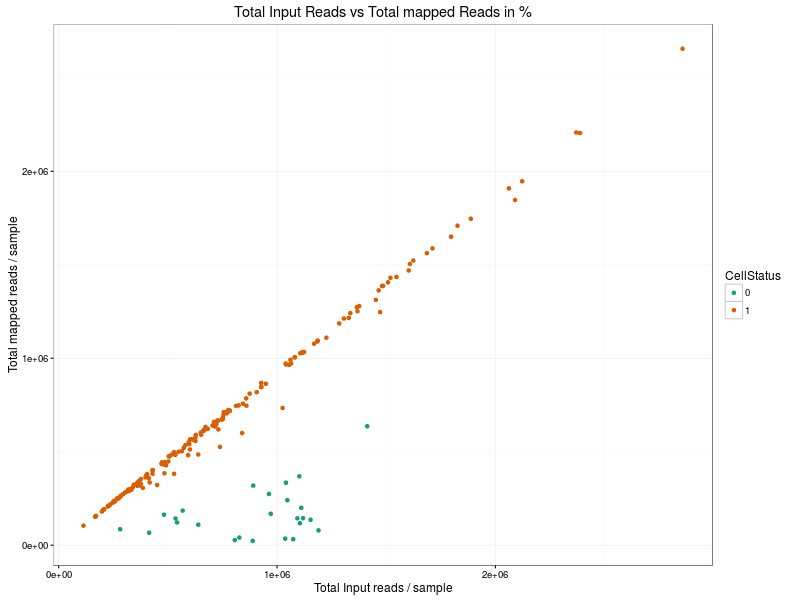

In [24]:
%%R -w 800 -h 600
df<-data.frame(X=MappingSummary$Number_of_input_reads,Y=MappingSummary$Uniquely_mapped_reads_number, CellStatus=as.factor(MappingSummary$CellNumber))
p <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Total Input Reads vs Total mapped Reads in %") +
     geom_point(size=1.5) +
     labs(x = "Total Input reads / sample", y = "Total mapped reads / sample") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()
     #geom_text(data=df,aes(label=names(mRNAno)),
     #          alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
           

print(p)

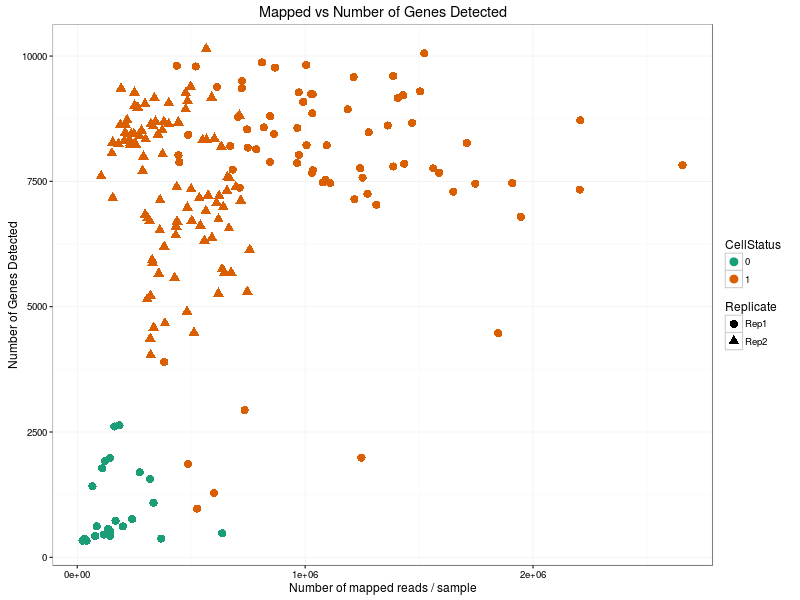

In [43]:
%%R -w 800 -h 600
df<-data.frame(X=MappingSummary$Uniquely_mapped_reads_number,Y=MappingSummary$No_Genes_Detected, 
               CellStatus=as.factor(MappingSummary$CellNumber),Replicate = as.factor(MappingSummary$ReplicateNumber))
p <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Mapped vs Number of Genes Detected") +
     geom_point(aes_string(shape="Replicate"),size=3.5) +
     labs(x = "Number of mapped reads / sample", y = "Number of Genes Detected") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()
     #geom_text(data=df,aes(label=names(mRNAno)),
     #          alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
           

print(p)

We now apply __Linear Discrimant Analysis (LDA)__ to see whether the cell numbers that we get from the Genome Facility agrees with our discrimant analysis. LDA is a classification method. LDA is based upon the concept of searching for a linear combination of variables (predictors) that best separates two classes (targets). The general LDA approach is very similar to a Principal Component Analysis, but in addition to finding the component axes that maximize the variance of our data (PCA), we are additionally interested in the axes that maximize the separation between multiple classes (LDA). The original Linear discriminant was described for a 2-class problem, and it was then later generalized as “multi-class Linear Discriminant Analysis”.

In [48]:
%%R
## create 3 groups according to cell number
group_3 <- rep("multiple cells",dim(MappingSummary)[1])
         group_3[grep("0", MappingSummary$CellNumber)] <- "no cells"
         group_3[grep("1", MappingSummary$CellNumber)] <- "one cell"

## create data frame
data_lda <- data.frame(cell_number = MappingSummary$CellNumber,
                       mapped_reads = MappingSummary$Uniquely_mapped_reads_number,
                       total_gene = MappingSummary$No_Genes_Detected,
                       group = group_3)

plot_before <- ggplot(data_lda, aes(x = mapped_reads, y = total_gene,
               color = as.factor(group))) +
               geom_text(aes(label = cell_number)) +
               labs(x = "Total Mapped Reads", 
                    y = "Total mRNA", 
                    title = "Before linear discriminant analysis (LDA) \n A few samples with one cell (purple) \n 
                            clustered with samples with 0 cells (green)") +
               scale_color_brewer(palette = "Dark2") +
               theme(legend.position = "none")

## perform lda
data_con_lda <- lda(group ~ mapped_reads + total_gene,
                    data = data_lda)
data_con_lda_p <- predict(data_con_lda, 
                          newdata = data_lda[,c("mapped_reads", "total_gene")])$class

## determine how well the model fix
#table(data_con_lda_p, data_lda[, "group"])
table(data_con_lda_p)

data_con_lda_p
no cells one cell 
      30      162 


In [49]:
%%R
data_lda$data_con_lda_p <- data_con_lda_p

plot_after <- ggplot(data_lda, aes(x = mapped_reads, y = total_gene,
               color = as.factor(data_con_lda_p))) +
               geom_text(aes(label = cell_number)) +
               labs(x = "Total Mapped Reads", 
                    y = "Total mRNA", 
                      title = "After linear discriminant analysis (LDA) \n Removal of samples classified as \n samples with 0 cells (green)") +
               scale_color_brewer(palette = "Dark2") +
               theme(legend.position = "none")
               #geom_text(data=data_lda,aes(label=rownames(data_lda)),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")

## identify the outlier 
outliers_lda <- data_lda %>% filter(cell_number == 1, data_con_lda_p == "no cells")
outliers_lda$sample_id

NULL


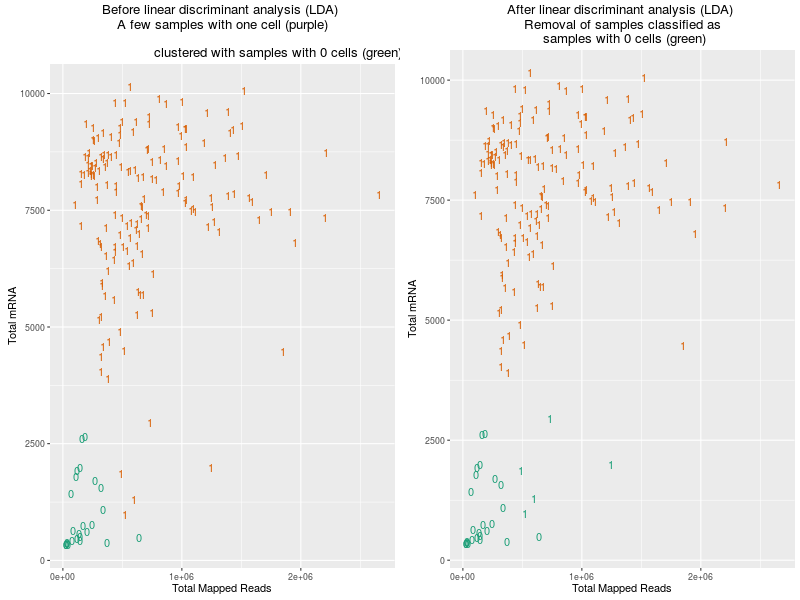

In [50]:
%%R -w 800 -h 600
multiplot(plot_before, plot_after, cols = 2)

It looks like that the LDA has picked one cell as 0 which is Cell 87

We will now do a density plot to choose the cutoff value for our QC

In [53]:
%%R
cut_off_reads <- quantile(MappingSummary[MappingSummary$CellNumber == 0, "Uniquely_mapped_reads_number"], 0.95)
plot_reads <- ggplot(MappingSummary[MappingSummary$CellNumber == 0 |
                                           MappingSummary$CellNumber == 1 , ],
       aes(x = Uniquely_mapped_reads_number, fill = as.factor(CellNumber))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_reads, colour="grey", linetype = "longdash") +
       labs(x = "Total mapped reads per sample", title = "Cutoff based on the number of total mappred reads", fill = "Cell number")


cut_off_mRNA <- quantile(MappingSummary[MappingSummary$CellNumber == 0, "mRNAno"], 0.95)
plot_mRNA <- ggplot(MappingSummary[MappingSummary$CellNumber == 0 |
                                           MappingSummary$CellNumber == 1 , ],
       aes(x = mRNAno, fill = as.factor(CellNumber))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_mRNA, colour="grey", linetype = "longdash") +
       labs(x = "mRNA per sample", title = "Cutoff based on the number of mRNAs",fill = "Cell number")

cut_off_genes <- quantile(MappingSummary[MappingSummary$CellNumber == 0, "No_Genes_Detected"], 0.95)
plot_gene <- ggplot(MappingSummary[MappingSummary$CellNumber == 0 |
                                           MappingSummary$CellNumber == 1 , ],
       aes(x = No_Genes_Detected, fill = as.factor(CellNumber))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_genes, colour="grey", linetype = "longdash") +
       labs(x = "Gene numbers per sample", title = "Cutoff based on the number of genes",fill = "Cell number")

cut_off_unmapped_ratio <- quantile(MappingSummary[MappingSummary$CellNumber == 0, "unmapped_ratios"], 0.95)
plot_unmapped_ratio <- ggplot(MappingSummary[MappingSummary$CellNumber == 0 |
                                           MappingSummary$CellNumber == 1 , ],
       aes(x = unmapped_ratios *100, fill = as.factor(CellNumber))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_unmapped_ratio *100, colour="grey", linetype = "longdash") +
       labs(x = "Unmapped reads / Total reads per sample", title = "Cutoff based on the mapped/unmapped ratio", fill = "Cell number")

cut_off_unmapped <- quantile(MappingSummary[MappingSummary$CellNumber == 0, "Percent_of_unmapped"], 0.95)
plot_unmapped <- ggplot(MappingSummary[MappingSummary$CellNumber == 0 |
                                           MappingSummary$CellNumber == 1 , ],
       aes(x = Percent_of_unmapped, fill = as.factor(CellNumber))) + 
       geom_density(alpha = 0.5) +
       geom_vline(xintercept = cut_off_unmapped, colour="grey", linetype = "longdash") +
       labs(x = "Percent of Unmapped reads", title = "Cutoff based on the percentage unmapped reads", fill = "Cell number")


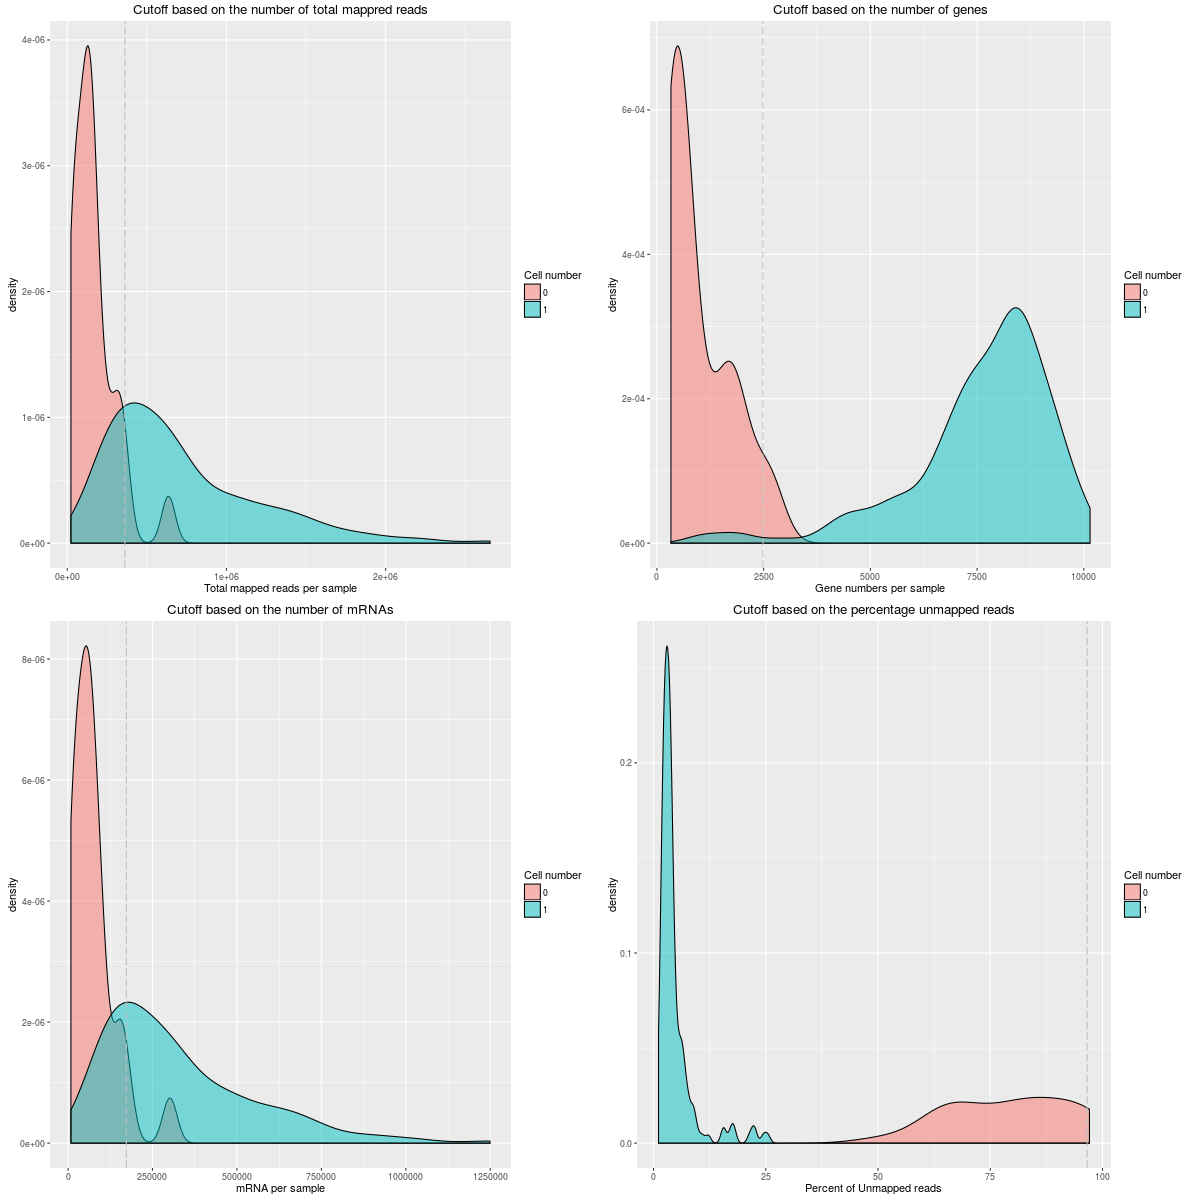

In [54]:
%%R -w 1200 -h 1200
multiplot(plot_reads, plot_mRNA, plot_gene, plot_unmapped, cols=2)

In [55]:
%%R
print(paste0("Cutoff Reads: ",cut_off_reads))
print(paste0("Cutoff mRNA: ",cut_off_mRNA))
print(paste0("Cutoff genes: ",cut_off_genes))
print(paste0("Cutoff Mapped/Unmapped ratio: ",cut_off_unmapped_ratio))
print(paste0("Cutoff Percent Unmapped reads: ",cut_off_unmapped))

[1] "Cutoff Reads: 361746.2"
[1] "Cutoff mRNA: 172453.6"
[1] "Cutoff genes: 2484.8"
[1] "Cutoff Mapped/Unmapped ratio: 0.565986047801851"
[1] "Cutoff Percent Unmapped reads: 96.58"


## Indication of cutoff
The previous figure gives an indication about different cut-off values that we can use to filter out the No-captured cells. However we will still apply `scde::clean.counts` to do the filtering. However, we can use the default read counts for this.

## Coefficient of Variation

In [56]:
%%R
CV <- function(mean, sd){
      (sd/mean)^2
}

In [57]:
%%R
cellCV <- CV(colMeans(cdAnnotAll),apply(cdAnnotAll, 2, sd))
mRNACV <- CV(rowMeans(cdAnnotAll),apply(cdAnnotAll, 1, sd))

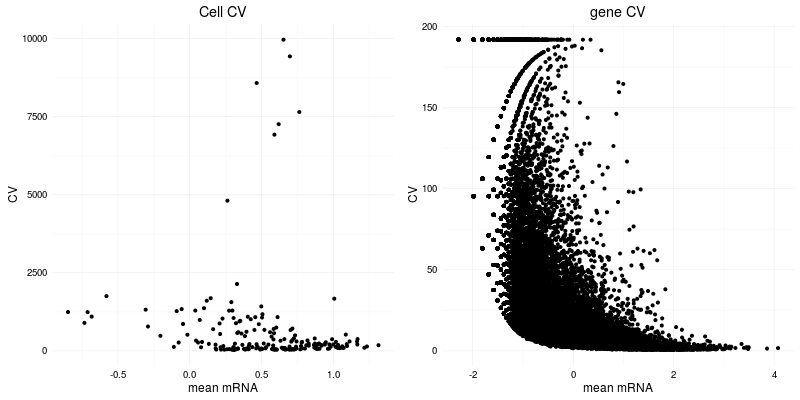

In [58]:
%%R -w 800 -h 400
df <- data.frame(X=log10(colMeans(cdAnnotAll)),Y=cellCV)
cellP <- ggplot(df, aes_string(x="X",y ="Y")) + 
      ggtitle("Cell CV") +
      geom_point(size=1.25) +
      labs(x = "mean mRNA", y = "CV") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

df <- data.frame(X=log10(rowMeans(cdAnnotAll)),Y=mRNACV)
mRNAP <- ggplot(df, aes_string(x="X",y ="Y")) + 
      ggtitle("gene CV") +
      geom_point(size=1.25) +
      labs(x = "mean mRNA", y = "CV") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

multiplot(cellP, mRNAP, cols=2)

## Applying scater on the whole dataset (without filtering the bad cells)

In [125]:
%%R
Rep1No <- (sum(sapply(regmatches(MappingSummary$ReplicateNumber, gregexpr("Rep1", MappingSummary$ReplicateNumber)), length)))
Rep2No <- (sum(sapply(regmatches(MappingSummary$ReplicateNumber, gregexpr("Rep2", MappingSummary$ReplicateNumber)), length)))
print(paste0("Replicate-1 Cells: ",Rep1No))
print(paste0("Replicate-2 Cells: ",Rep2No))

[1] "Replicate-1 Cells: 96"
[1] "Replicate-2 Cells: 96"


In [126]:
%%R
DataInfo <- data.frame(Cell=colnames(cdAnnotAll), Replicate=c(rep('Rep1',Rep1No), rep('Rep2',Rep2No)) )
rownames(DataInfo) <- colnames(cdAnnotAll)
pd <- new("AnnotatedDataFrame", data = DataInfo)
rownames(pd) <- pd$Cell
cdSceset <- newSCESet(countData = cdAnnotAll, phenoData = pd)
cdSceset <- calculateQCMetrics(cdSceset)

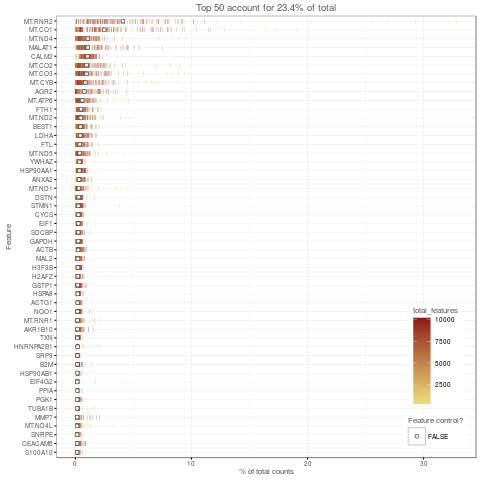

In [127]:
%%R
plotQC(cdSceset, type = "highest-expression")

The above figure shows how much of the total reads are taken by the top 50% genes.

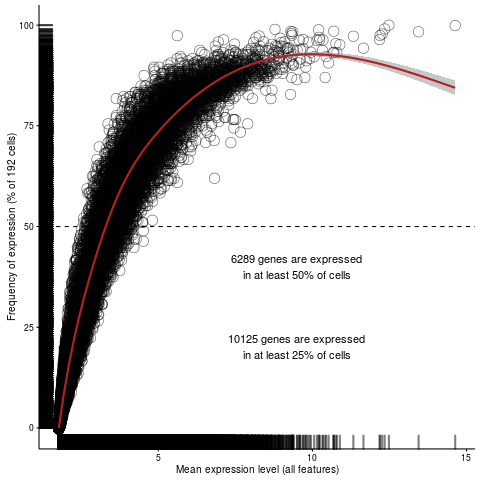

In [128]:
%%R
plotQC(cdSceset, type = "exprs-freq-vs-mean")

The above figure shows how many genes are expressed based on the percent of totall cells (192 cells in our case).

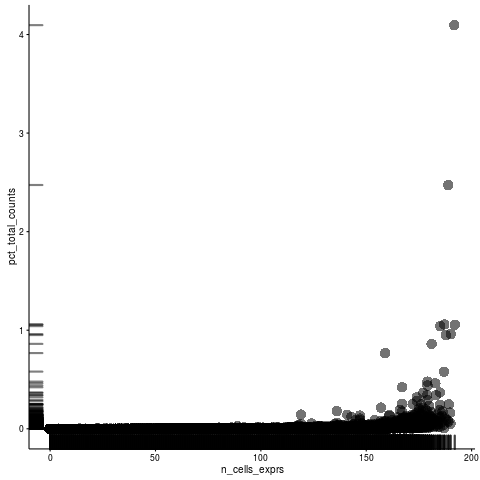

In [129]:
%%R
plotFeatureData(cdSceset, aes(x = n_cells_exprs, y = pct_total_counts))

The above figure shows what percent of genes are expressed across how many cells. Each of the dots represent a gene. The Y-axis shows the percent of total counts that each of the gene took. Here we see a fair number of genes are expressed across all the cells and few of them are taking a large portion of all the reads.

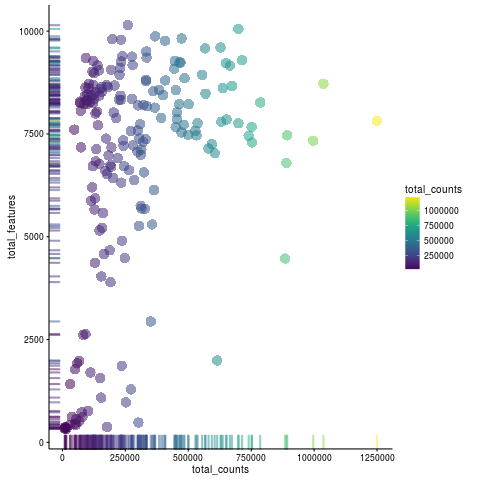

In [130]:
%%R
plotPhenoData(cdSceset, aes(x = total_counts, y = total_features,
                                  colour = total_counts))

In the above figure it shows, how many total features(feature represents gene here) are found across total_counts. For the highest count we see that number of total features are not the maximum. This indicates that there are few genes which takes up majority of the reads.

## Cell Filtering
__This is a major step to remove the bad cells__

We will now filter the cells. We will still apply `scde::clean.counts` to filter out the bed cells. However, after filtering we will look at the previous figures so confirm whether they agree with our threshold and with our identification of bad cells

In [93]:
%%R
cdFiltered <- clean.counts(cdAnnotAll, min.lib.size = 1800, min.reads = 10,min.detected = 5)
print(paste("Before Filtering (genes): ", dim(cdAnnotAll)[1]))
print(paste("Before Filtering (Cells): ", dim(cdAnnotAll)[2]))
print(paste("After Filtering (genes): ", dim(cdFiltered)[1]))
print(paste("After Filtering (cells): ", dim(cdFiltered)[2]))

[1] "Before Filtering (genes):  60554"
[1] "Before Filtering (Cells):  192"
[1] "After Filtering (genes):  17165"
[1] "After Filtering (cells):  169"


After filtering although it keeps 169 cells out of 192 cells. The filtering criteria I followed are

- min.lib.size:	Minimum number of genes detected in a cell. Cells with fewer genes will be removed (1500)
- min.reads: Minimum number of reads per gene. Genes with fewer reads will be removed (10)
- min.detected: Minimum number of cells a gene must be seen in. Genes not seen in a sufficient number of cells will be removed (5)


To see how many cells were left after the filtering we plot one of the previous ones again.

In [94]:
%%R
MappingSummaryFilt <- MappingSummary[as.character(MappingSummary$CellName) %in% colnames(cdFiltered),]

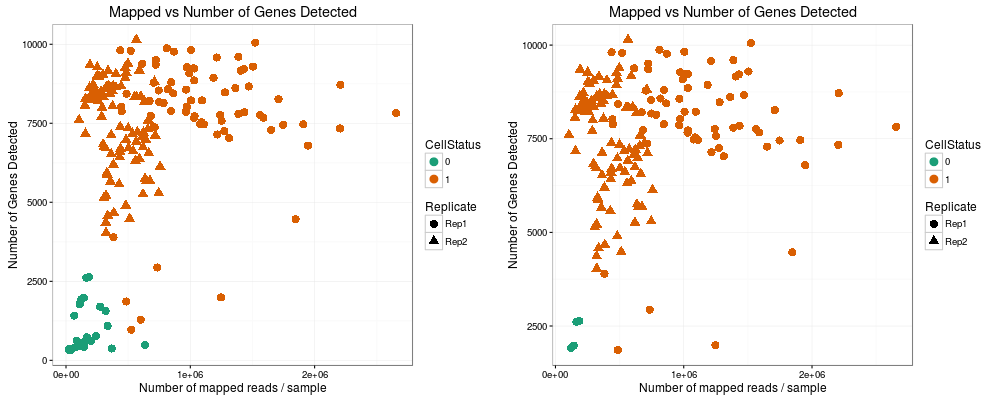

In [95]:
%%R -w 1000 -h 400
df<-data.frame(X=MappingSummary$Uniquely_mapped_reads_number,Y=MappingSummary$No_Genes_Detected, 
               CellStatus=as.factor(MappingSummary$CellNumber),Replicate = as.factor(MappingSummary$ReplicateNumber))
p1 <- ggplot(df, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Mapped vs Number of Genes Detected") +
     geom_point(aes_string(shape="Replicate"),size=3.5) +
     labs(x = "Number of mapped reads / sample", y = "Number of Genes Detected") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()
     #geom_text(data=df,aes(label=names(mRNAno)),
     #          alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")

df2<-data.frame(X=MappingSummaryFilt$Uniquely_mapped_reads_number,Y=MappingSummaryFilt$No_Genes_Detected, 
               CellStatus=as.factor(MappingSummaryFilt$CellNumber),Replicate = as.factor(MappingSummaryFilt$ReplicateNumber))
p2 <- ggplot(df2, aes_string(x="X",y ="Y",color="CellStatus")) + 
     ggtitle("Mapped vs Number of Genes Detected") +
     geom_point(aes_string(shape="Replicate"),size=3.5) +
     labs(x = "Number of mapped reads / sample", y = "Number of Genes Detected") +
     scale_color_brewer(palette = "Dark2") +
     theme_bw()
     #geom_text(data=df,aes(label=names(mRNAno)),
     #          alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")


multiplot(p1, p2,cols=2)

Looking at the figures above we see there are still some cells which are 0 marked (green ones). A close observation says that although they are 0 their read counts are still within acceptable range. Looking at the scale of Y-axis this becomes more clear. So I will not do additional filtering to discard the remaining green marked cells.

In [222]:
%%R
Rep1No <- (sum(sapply(regmatches(MappingSummaryFilt$ReplicateNumber, gregexpr("Rep1", MappingSummaryFilt$ReplicateNumber)), length)))
Rep2No <- (sum(sapply(regmatches(MappingSummaryFilt$ReplicateNumber, gregexpr("Rep2", MappingSummaryFilt$ReplicateNumber)), length)))
print(paste0("After filtering Replicate-1 Cells: ",Rep1No))
print(paste0("After filtering Replicate-2 Cells: ",Rep2No))

[1] "After filtering Replicate-1 Cells: 73"
[1] "After filtering Replicate-2 Cells: 96"


In [133]:
%%R
FilteredDataInfo <- data.frame(Cell=colnames(cdFiltered), Replicate=c(rep('Rep1',Rep1No), rep('Rep2',Rep2No)))
rownames(FilteredDataInfo ) <- colnames(cdFiltered)
pd <- new("AnnotatedDataFrame", data = FilteredDataInfo)
rownames(pd) <- pd$Cell
cdScesetFiltered <- newSCESet(countData = cdFiltered, phenoData = pd)
cdScesetFiltered <- calculateQCMetrics(cdScesetFiltered)

The name of the cells that remains after filtering are listed below

In [134]:
%%R
colnames(cdFiltered)

  [1] "C02_rep1" "C03_rep1" "C04_rep1" "C05_rep1" "C06_rep1" "C08_rep1"
  [7] "C10_rep1" "C11_rep1" "C12_rep1" "C13_rep1" "C14_rep1" "C15_rep1"
 [13] "C16_rep1" "C17_rep1" "C20_rep1" "C21_rep1" "C22_rep1" "C23_rep1"
 [19] "C24_rep1" "C25_rep1" "C26_rep1" "C27_rep1" "C29_rep1" "C30_rep1"
 [25] "C32_rep1" "C34_rep1" "C35_rep1" "C36_rep1" "C37_rep1" "C38_rep1"
 [31] "C39_rep1" "C40_rep1" "C41_rep1" "C42_rep1" "C43_rep1" "C44_rep1"
 [37] "C45_rep1" "C46_rep1" "C47_rep1" "C48_rep1" "C49_rep1" "C50_rep1"
 [43] "C51_rep1" "C52_rep1" "C53_rep1" "C55_rep1" "C56_rep1" "C57_rep1"
 [49] "C58_rep1" "C59_rep1" "C60_rep1" "C61_rep1" "C63_rep1" "C64_rep1"
 [55] "C67_rep1" "C68_rep1" "C70_rep1" "C71_rep1" "C72_rep1" "C73_rep1"
 [61] "C74_rep1" "C77_rep1" "C78_rep1" "C80_rep1" "C82_rep1" "C86_rep1"
 [67] "C87_rep1" "C88_rep1" "C89_rep1" "C93_rep1" "C94_rep1" "C95_rep1"
 [73] "C96_rep1" "C01_rep2" "C02_rep2" "C03_rep2" "C04_rep2" "C05_rep2"
 [79] "C06_rep2" "C07_rep2" "C08_rep2" "C09_rep2" "C10_rep2" "C1

## Coefficient of Variation after filtering

In [135]:
%%R
cellCVFiltered <- CV(colMeans(cdFiltered),apply(cdFiltered, 2, sd))
mRNACVFiltered <- CV(rowMeans(cdFiltered),apply(cdFiltered, 1, sd))

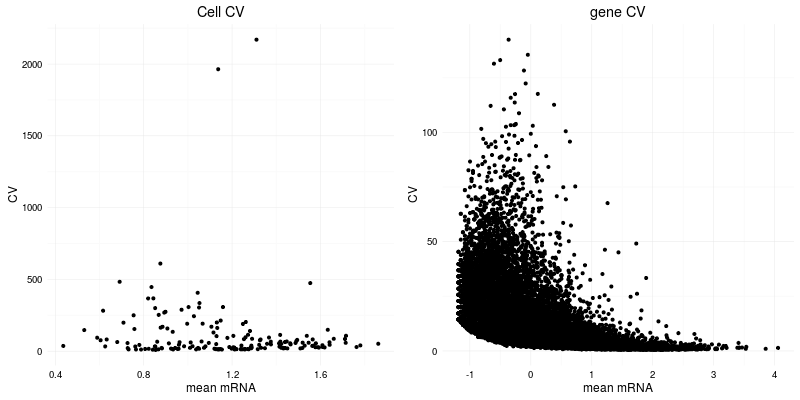

In [136]:
%%R -w 800 -h 400
df <- data.frame(X=log10(colMeans(cdFiltered)),Y=cellCVFiltered)
cellP <- ggplot(df, aes_string(x="X",y ="Y")) + 
      ggtitle("Cell CV") +
      geom_point(size=1.25) +
      labs(x = "mean mRNA", y = "CV") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

df <- data.frame(X=log10(rowMeans(cdFiltered)),Y=mRNACVFiltered)
mRNAP <- ggplot(df, aes_string(x="X",y ="Y")) + 
      ggtitle("gene CV") +
      geom_point(size=1.25) +
      labs(x = "mean mRNA", y = "CV") +
      theme_bw()+
      theme(legend.position = "none",
            legend.background = element_rect(fill = "white"),
            strip.background = element_blank(),
            strip.text.x     = element_blank(),
            axis.ticks       = element_blank(),
            axis.line        = element_blank(),
            panel.border     = element_blank())

multiplot(cellP, mRNAP, cols=2)

In [137]:
%%R
write.csv(exprs(cdScesetFiltered), 'log2(cpm+1)_normalized_read_counts.csv')

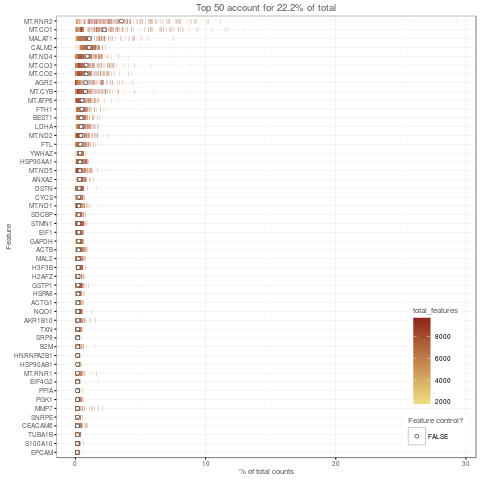

In [138]:
%%R
plotQC(cdScesetFiltered, type = "highest-expression")

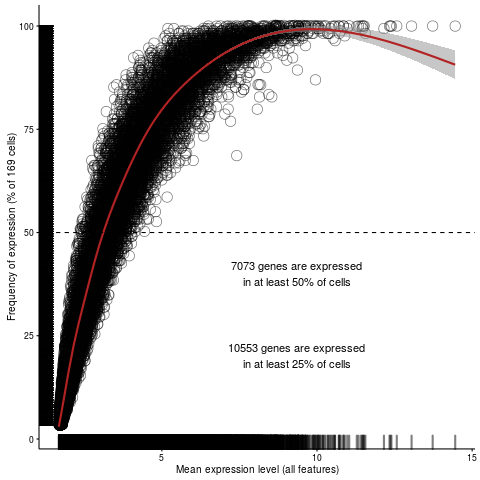

In [139]:
%%R
plotQC(cdScesetFiltered, type = "exprs-freq-vs-mean")

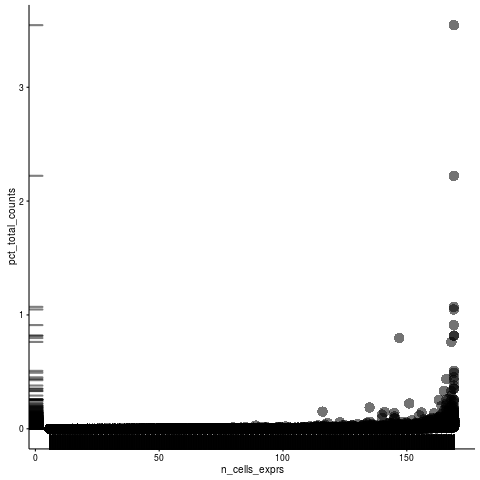

In [140]:
%%R
plotFeatureData(cdScesetFiltered, aes(x = n_cells_exprs, y = pct_total_counts))

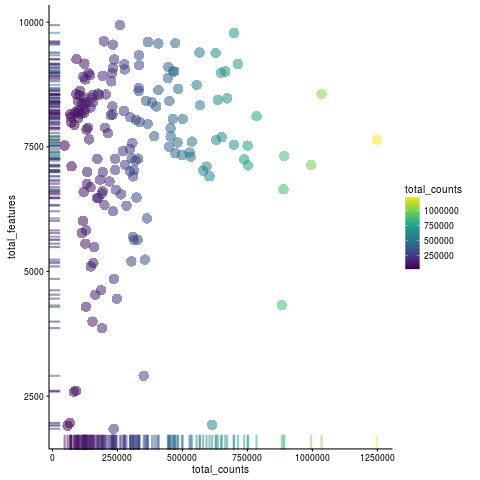

In [141]:
%%R
plotPhenoData(cdScesetFiltered, aes(x = total_counts, y = total_features,
                                  colour = total_counts))

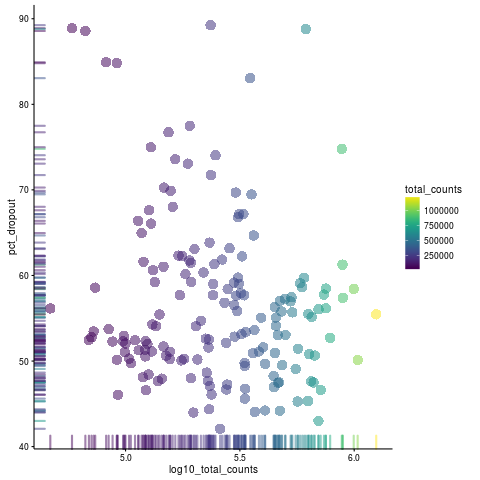

In [142]:
%%R
plotPhenoData(cdScesetFiltered, aes(x = log10_total_counts, y = pct_dropout,
                                  colour = total_counts))

* * *

## Starting analysis
From this point we start with the analysis we are looking for. As the samples from each of the replicate have a mixture of OE19, OE33 and HET1A human cells, we would expect to see three distinct clusters in both the replicates.

#### PCA with 500 top mostly variable genes

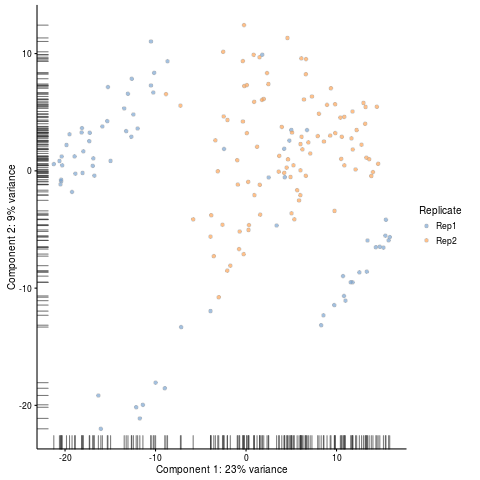

In [156]:
%%R
plotPCA(cdScesetFiltered, ncomponents = 2, colour_by = "Replicate")

Although we could see that for rep1 three distinct clusters appear, we cannot say that definitely for rep2.

### PCA with top 500 most variable genes. The plot below plots 4 principle components with the dataset

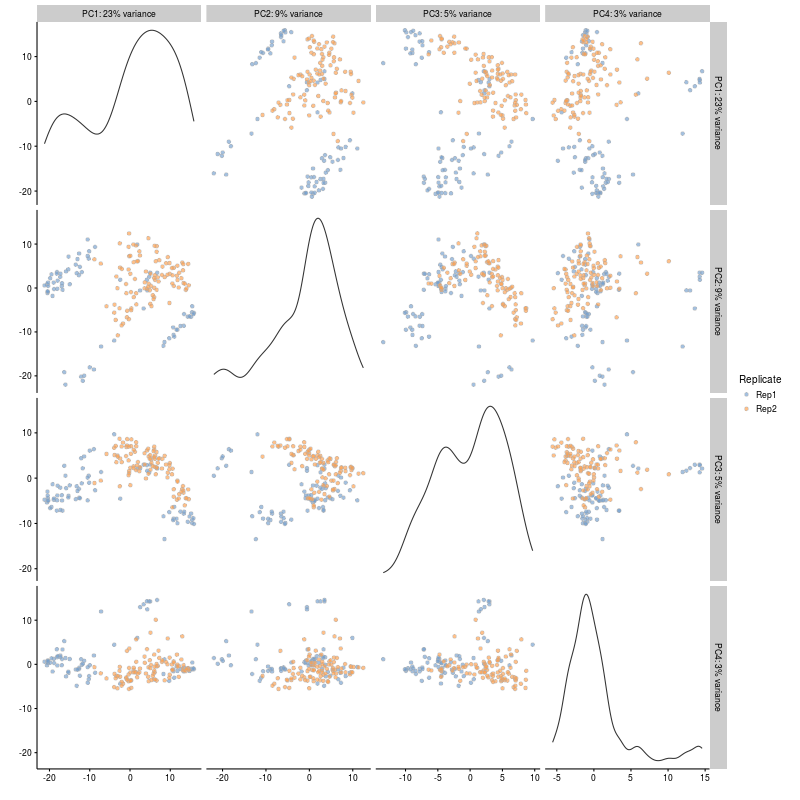

In [146]:
%%R -w 800 -h 800
plotPCA(cdScesetFiltered, ncomponents = 4, colour_by = "Replicate")

### PCA with all the genes

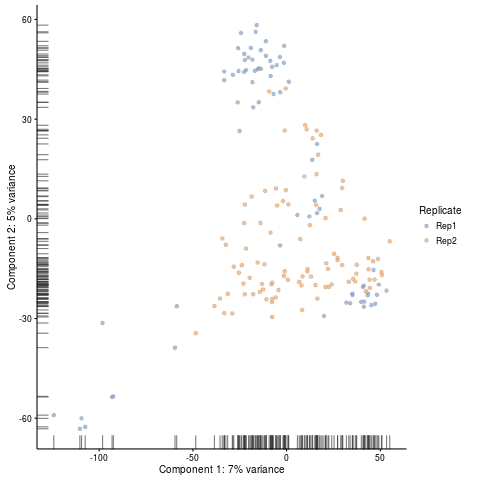

In [145]:
%%R
plotPCA(cdScesetFiltered, ncomponents = 2, ntop=dim(cdFiltered)[1], colour_by = "Replicate")

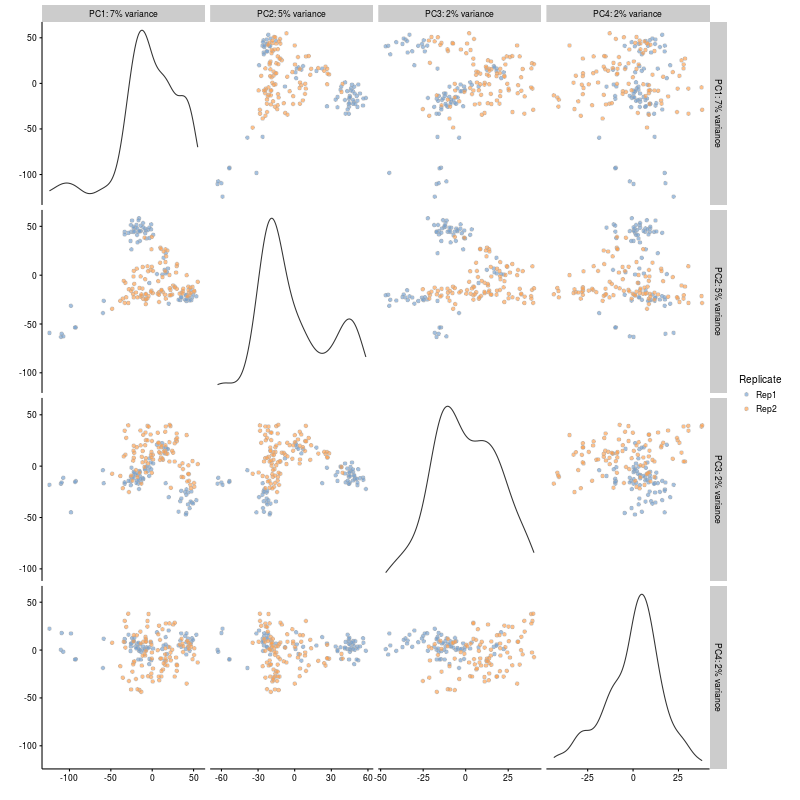

In [147]:
%%R -w 800 -h 800
plotPCA(cdScesetFiltered, ncomponents = 4, ntop=dim(cdFiltered)[1], colour_by = "Replicate")

#### t-SNE
We are now applying t-SNE to see whether the visualization improves

In [173]:
%%R
#set.seed(1)
tsne_out <- Rtsne(t(exprs(cdScesetFiltered)),check_duplicates = FALSE, pca = TRUE, 
              perplexity=30, theta=0.5, dims=2)

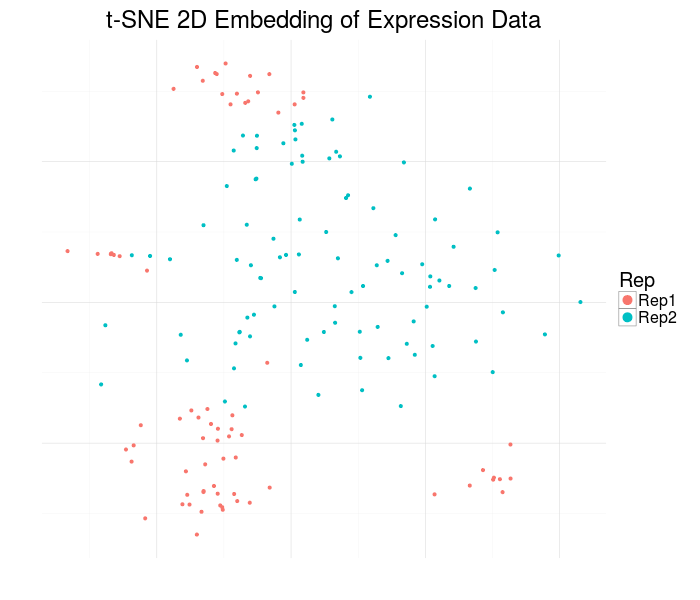

In [174]:
%%R -w 700 -h 600
Rep <- as.factor(MappingSummaryFilt$ReplicateNumber)
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=Rep)) +
     geom_point(size=1.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

In [155]:
%%R
save.image("Syed_Workspace.RData")

### Heatmap

In [151]:
%%R
# Taking CPM normalized value for clustering from cdScesetFiltered
cdFilteredForCluster <- exprs(cdScesetFiltered)
cdFilteredForCluster <- cdFilteredForCluster[order(rowVars(cdFilteredForCluster), decreasing = TRUE)[1:10000],]
colAnnot = data.frame(type = c(rep('Rep1',Rep1No), rep('Rep2',Rep2No)))
ha = HeatmapAnnotation(df = colAnnot)

###############################
# I turned this Heatmap option off as it took lots of memory to run from jupyter notebook
png("CPM_Normalized_Low_Threshold_HirerClust.png", height=1000, width=1700)
Heatmap(cdFilteredForCluster, show_row_dend=FALSE, show_row_names = FALSE, column_names_gp = gpar(fontsize = 9), top_annotation = ha)
dev.off()

png 
  2 


### M3Drop to find Differentially Expressed Genes
Using MM3Drop to find the differentially expressed genes. MM3Drop use Michaelis-Menten curve to find differentially expressed (DE) genes. I found this technique to give the best result with respect to FDR. However, they do not say which group of genes they are differentially expressed.

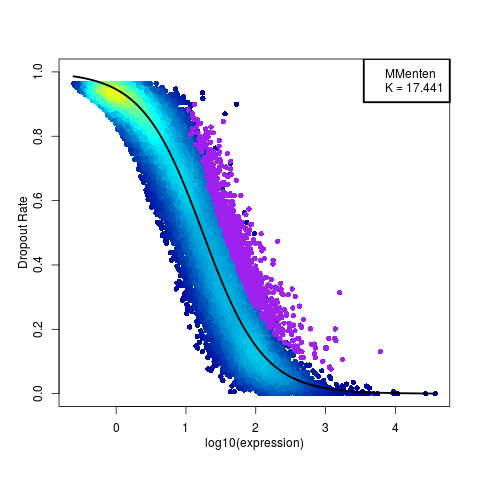

In [220]:
%%R
M3DropSignificantGenes <- M3DropDifferentialExpression(2^exprs(cdScesetFiltered), mt_threshold=0.05)

In [221]:
%%R
write.csv(M3DropSignificantGenes, 'M3DropSignificantGenes.csv')

### Identifying Cell-cycles 

In [212]:
%%R
plot.scores.self <- function(df, Cell, Replicate,legend.title, plot.title){  
  df$Replicate <- as.factor(Replicate) 
  p<-ggplot(data=df, aes(x=x,y=y,color=Replicate))
  p+geom_point(size=3)+
    xlab("G1 score")+
    ylab("G2M score")+
    ylim(0,1)+
    xlim(0,1)+
    ggtitle(plot.title)+
    theme(axis.title.x = element_text(size=10, vjust=-2),
          axis.text.x  = element_text( size=10),
          axis.title.y = element_text( size=10,vjust=2),
          axis.text.y  = element_text( size=10)) +
    theme(plot.margin=unit(c(1,1,1.5,1.2),"cm"))+
    theme(legend.text=element_text(size=10),#size of legend
          legend.title=element_text(size=10), 
          plot.title = element_text(size=20, face="bold"))+
    scale_color_discrete(name=legend.title)+
    geom_segment(aes(x = 1/2, y = 0, xend=1/2, yend=1/2),colour="black") + 
    geom_segment(aes(x = 0, y = 1/2, xend=1/2, yend=1/2),colour="black") +
    geom_segment(aes(x = 1/2, y = 1/2, xend=1, yend=1),colour="black") +
    annotate("text", x=0.05, y=0.05, label="S", size=6)+
    annotate("text", x=0.95, y=0.25, label="G1", size=6)+
    annotate("text", x=0.25, y=0.95, label="G2M", size=6)+
    geom_text(data=df,aes(label=Cell),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")+
    theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
  
}

In [183]:
%%R
cdRep1 <- read.table("/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/AllReads/AllHtseqCounts_Rep1.csv", sep=",",header=TRUE, row.names=1)
cdRep2 <- read.table("/home/baker/Rna-seq_Data-Analysis/Syed_scATAC_and_scRNA_Comparison/AllReads/AllHtseqCounts_Rep2.csv", sep=",",header=TRUE, row.names=1)

cdAnnotRep1GeneID <- cdRep1
colnames(cdAnnotRep1GeneID) <- gsub('(_).*','_rep1', colnames(cdAnnotRep1GeneID))


cdAnnotRep2GeneID <- cdRep2
colnames(cdAnnotRep2GeneID) <- gsub('(_).*','_rep2', colnames(cdAnnotRep2GeneID))
cdAnnotAllGeneID <- cbind(cdAnnotRep1GeneID, cdAnnotRep2GeneID)
rownames(cdAnnotAllGeneID) <- gsub("\\..*","",rownames(cdAnnotAllGeneID))

cdAnnotAllGeneIDFilt <- clean.counts(cdAnnotAllGeneID, min.lib.size = 1800, min.reads = 10,min.detected = 5)

FilteredDataInfoGeneID <- data.frame(Cell=colnames(cdAnnotAllGeneIDFilt), Replicate=c(rep('Rep1',Rep1No), rep('Rep2',Rep2No)))
rownames(FilteredDataInfoGeneID) <- colnames(cdAnnotAllGeneIDFilt)
pd <- new("AnnotatedDataFrame", data = FilteredDataInfoGeneID)
rownames(pd) <- pd$Cell
cdScesetFilteredGeneID <- newSCESet(countData = cdAnnotAllGeneIDFilt, phenoData = pd)
cdScesetFilteredGeneID <- calculateQCMetrics(cdScesetFilteredGeneID)
hg.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))

In [191]:
%%R
save.image("Syed_Workspace.RData")

In [186]:
%%R
assigned <- cyclone(cdScesetFilteredGeneID, pairs=hg.pairs)

In [190]:
%%R
phase <- rep("S", ncol(cdScesetFilteredGeneID))
phase[assigned$scores$G1 > 0.5] <- "G1"
phase[assigned$scores$G2M > 0.5] <- "G2M"
phase[assigned$scores$G1 > 0.5 & assigned$scores$G2M > 0.5] <- "unknown"
table(paste0('Assignment of cells: ',phase))


     Assignment of cells: G1     Assignment of cells: G2M 
                          64                           35 
      Assignment of cells: S Assignment of cells: unknown 
                           5                           65 


We now plot the assignments of the cells. As mentioned earlier cells assigned close the boundary are not conclusive, so should not be used for further analysis.

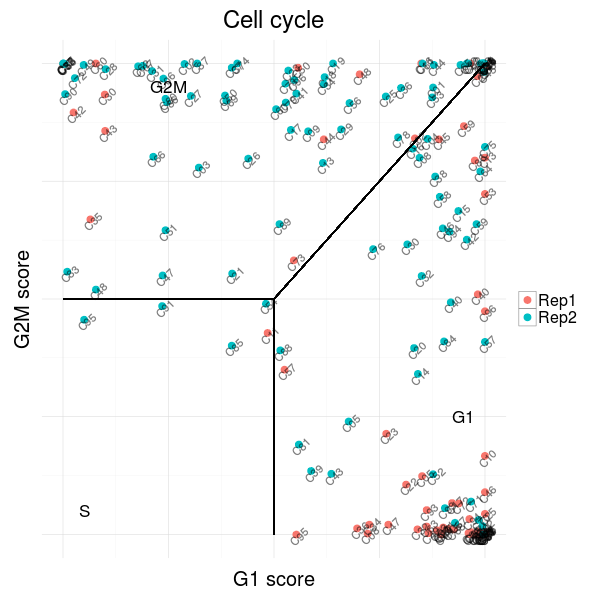

In [213]:
%%R -w 600 -h 600
#assigned$scores
labels.qseq <- rep("Cell", length(colnames(cdAnnotAllGeneIDFilt)) )
df.scores<-data.frame(x=assigned$scores[,1], 
                      y=assigned$scores[,3], 
                      z=labels.qseq )

plot.scores.self(df.scores,gsub('(_rep.*)', '',(cdScesetFilteredGeneID$Cell)), cdScesetFilteredGeneID$Replicate, legend.title="",plot.title="Cell cycle")

Printing the Assignment scores. The highest assignment for a cell would be assigned to that cell-cycle. However, the cells on the boundary regions would not be considered.

## Removing cell-cycle effect
We will now remove the cell-cycle effect from our dataset as this could be a confounding factor for our analysis. In order to remove the cell-cycle effect we have to have cell-cycle annotated genes. For this annotation we will use the genes from Evan Z. Macosko paper [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4481139/)

### Cell-cycle Gene from Evan Z. Macosko

In [216]:
%%R
hgCellCycle <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/Cell-Cycle-Gene_Evan_Macosko.txt', header=TRUE)
x <- t(scale(t(exprs(cdScesetFilteredGeneID)), scale=FALSE, center=TRUE))
allGenes <- data.frame(geneName=rownames(x), Status=FALSE)
allGenes[as.character(allGenes$geneName) %in% hgCellCycle$Ensembl.Gene.ID,2] = TRUE
if.cc <- allGenes[,2]
dat <-list(x =x ,if.cc = if.cc)

In [218]:
%%R
CellCycleRemoved <- ccRemover.main(dat,cutoff=3, max.it=4, nboot=200, ntop=10)


Iteration  1 ...
Bootstrapping 1 ...
Bootstrapping 2 ...
Bootstrapping 3 ...
Bootstrapping 4 ...
Bootstrapping 5 ...
Bootstrapping 6 ...
Bootstrapping 7 ...
Bootstrapping 8 ...
Bootstrapping 9 ...
Bootstrapping 10 ...
Bootstrapping 11 ...
Bootstrapping 12 ...
Bootstrapping 13 ...
Bootstrapping 14 ...
Bootstrapping 15 ...
Bootstrapping 16 ...
Bootstrapping 17 ...
Bootstrapping 18 ...
Bootstrapping 19 ...
Bootstrapping 20 ...
Bootstrapping 21 ...
Bootstrapping 22 ...
Bootstrapping 23 ...
Bootstrapping 24 ...
Bootstrapping 25 ...
Bootstrapping 26 ...
Bootstrapping 27 ...
Bootstrapping 28 ...
Bootstrapping 29 ...
Bootstrapping 30 ...
Bootstrapping 31 ...
Bootstrapping 32 ...
Bootstrapping 33 ...
Bootstrapping 34 ...
Bootstrapping 35 ...
Bootstrapping 36 ...
Bootstrapping 37 ...
Bootstrapping 38 ...
Bootstrapping 39 ...
Bootstrapping 40 ...
Bootstrapping 41 ...
Bootstrapping 42 ...
Bootstrapping 43 ...
Bootstrapping 44 ...
Bootstrapping 45 ...
Bootstrapping 46 ...
Bootstrapping 47 ...
Boot

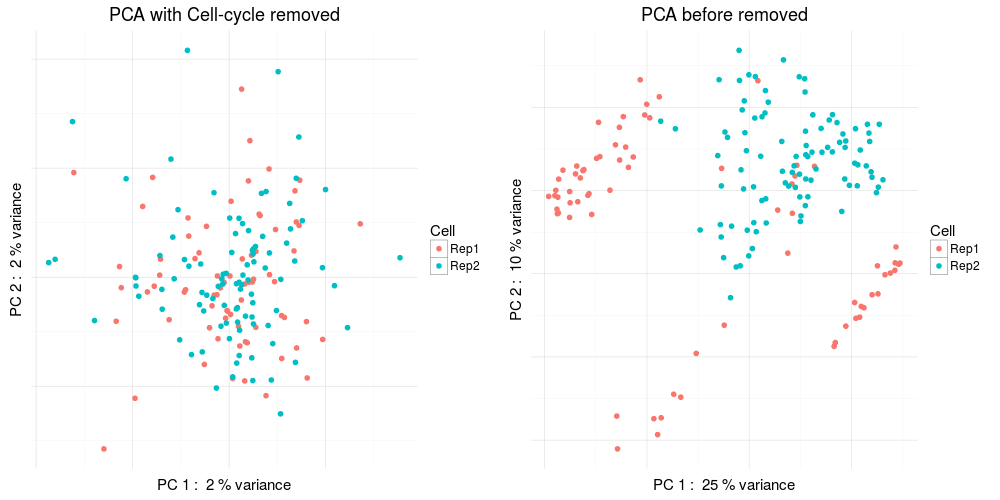

In [232]:
%%R -w 1000 -h 500
FinalPCAData <- t(CellCycleRemoved[order(rowVars(CellCycleRemoved), decreasing=TRUE)[1:500],])
sampleCondition <- FilteredDataInfoGeneID$Replicate
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with Cell-cycle removed")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#print(p1)

FinalPCAData <- t(exprs(cdScesetFilteredGeneID)[order(rowVars(exprs(cdScesetFilteredGeneID)), decreasing=TRUE)[1:500],])
sampleCondition <- FilteredDataInfoGeneID$Replicate
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p2<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p2<-p2+ggtitle("PCA before removed")
p2<-p2+geom_point(size = 2)
p2<-p2+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p2<-p2    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())

multiplot(p1,p2, cols=2)


The cell-cycle remover clearly removes a large portion of variance. Previously it was 25% but now only 2% on PC1. However, the visualization of the clustering does not improve.